Notebook outlining what functions from nltk will be useful for pre-processing the text and training the classification algorithm.

Expects a CSV file in the current directory containing a release's date, text, and classification (pos or neg) in each row.

In [1]:
import math
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import decomposition, linear_model
from sklearn.model_selection import train_test_split

Some pre-processing to get the dataframe into the format we need for content analysis.

In [61]:
release_df = pd.read_csv('release_df.csv', index_col=0)

In [62]:
release_df.tail()

,date,release_text,year,month
98,"June 29, 2006",The Federal Open Market Committee decided toda...,2006,June
99,"August 08, 2006",The Federal Open Market Committee decided toda...,2006,August
100,"September 20, 2006",The Federal Open Market Committee decided toda...,2006,September
101,"October 25, 2006",The Federal Open Market Committee decided toda...,2006,October
102,"December 12, 2006",The Federal Open Market Committee decided toda...,2006,December


- Need to add historical text data. DONE
- Need to add historical rate data. DONE
- Need to merge two datasets. DONE

`allratesdf.csv` contains cleaned DataFrame of all relevant rate changes from 1960.

In [33]:
allratesdf = pd.read_csv('allratesdf.csv', index_col=0)

In [63]:
allratesdf.head()

,month,year,Change,increase
0,February,1994,0.07,True
1,March,1994,0.03,True
2,April,1994,0.07,True
3,May,1994,0.13,True
4,June,1994,0.06,True


`ratesfrom06` is a cleaned DataFrame with rates from 2006 on, which is our set for analysis.

In [39]:
ratesfrom06 = allratesdf.iloc[143:]

In [41]:
ratesfrom06.reset_index(inplace=True, drop=True)

In [43]:
ratesfrom06.head()

,month,year,Change,increase
0,January,2006,0.03,True
1,February,2006,0.05,True
2,March,2006,0.02,True
3,April,2006,0.04,True
4,May,2006,0.03,True


Now, to merge the text and rates DataFrames and clean the result. `releaserates_df` has all rate changes since 2006 and their associated release text.

In [76]:
#releaserates_df = ratesfrom06.merge(release_df, how='left', on=['year', 'month'])
#releaserates_df = releaseratesdf.ffill()
releaserates_df = pd.read_csv('releaserates_df.csv', index_col=0)

In [78]:
releaserates_df.head()

,month,year,Change,increase,date,release_text
0,January,2006,0.03,True,"January 31, 2006",The Federal Open Market Committee decided toda...
1,February,2006,0.05,True,"January 31, 2006",The Federal Open Market Committee decided toda...
2,March,2006,0.02,True,"March 28, 2006",The Federal Open Market Committee decided toda...
3,April,2006,0.04,True,"March 28, 2006",The Federal Open Market Committee decided toda...
4,May,2006,0.03,True,"May 10, 2006",The Federal Open Market Committee decided toda...


Now text processing using `nltk`.

In [79]:
releaserates_df = pd.read_csv('releaserates_df.csv', index_col=0)

In [80]:
releaserates_df.head()

,month,year,Change,increase,date,release_text
0,January,2006,0.03,True,"January 31, 2006",The Federal Open Market Committee decided toda...
1,February,2006,0.05,True,"January 31, 2006",The Federal Open Market Committee decided toda...
2,March,2006,0.02,True,"March 28, 2006",The Federal Open Market Committee decided toda...
3,April,2006,0.04,True,"March 28, 2006",The Federal Open Market Committee decided toda...
4,May,2006,0.03,True,"May 10, 2006",The Federal Open Market Committee decided toda...


First, we try a Logistic Regression using PCA on tf-idf vectors.

In [81]:
x_train, x_test, y_train, y_test = train_test_split(releaserates_df['release_text'], releaserates_df['increase'], test_size = .20, random_state = 42)

In [82]:
releaseTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')

In [83]:
releaseTFVects = releaseTFVectorizer.fit_transform(x_train)

If interested in the scores assigned to words:

In [84]:
#sorted(list(zip(releaseTFVectorizer.vocabulary_.keys(), releaseTFVects.data)), key=lambda x: x[1], reverse=True)

In [85]:
PCA = decomposition.PCA
pca = PCA().fit(releaseTFVects.toarray())
reduced_data = pca.transform(releaseTFVects.toarray())

A Scree Plot indicating the proportion of variance explained by the first $x$ principal components.

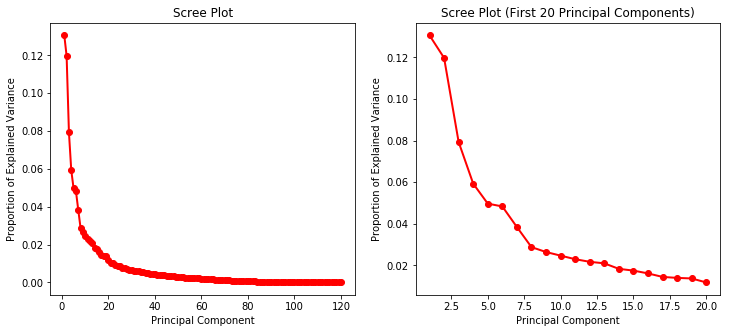

In [86]:
n = releaseTFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

We'll first try a Logistic Regression using the first 10 principal components as regressors.

In [87]:
X = reduced_data[:, :10]
Y = np.array([int(label) for label in y_train])

In [88]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.775


In [92]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.6333333333333333


Not so good...

How about 21 principal components? (Seems like a reasonable knee in the scree plot)

In [93]:
X = reduced_data[:, :21]
Y = np.array([int(label) for label in y_train])

In [97]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.8


In [98]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :21]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.6333333333333333


After this point, more components doesn't result in much of an increase in predictive power. But, this still isn't great. To solve this problem, we should try different classifying algorithms.